Problem Definition

Store Segmentation :  Identify the store level segments
    Outcomes : Redefine the store level funcitoning
               Learn from better performing store and apply the factors in non performing stores

Data dictionary

# Creation of base data set

In [116]:
# importing required libraries for data analysis
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

Merging multiple files

In [117]:
files=glob.glob("C:\\Users\\Administrator\\Documents\\Python Scripts\\Python\\Cluster\\rossmann-store-sales\\*.csv")

In [118]:
files

['C:\\Users\\Administrator\\Documents\\Python Scripts\\Python\\Cluster\\rossmann-store-sales\\sample_submission.csv',
 'C:\\Users\\Administrator\\Documents\\Python Scripts\\Python\\Cluster\\rossmann-store-sales\\store.csv',
 'C:\\Users\\Administrator\\Documents\\Python Scripts\\Python\\Cluster\\rossmann-store-sales\\test.csv',
 'C:\\Users\\Administrator\\Documents\\Python Scripts\\Python\\Cluster\\rossmann-store-sales\\train.csv']

In [119]:
df=pd.read_csv(files[3])

C:\Users\Administrator\Haritha\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [120]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [121]:
base_dataset_backup=df

 Data pre-processing

1. Memory Management

In [122]:
""" iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.        
"""

start_mem=df.memory_usage().sum()/1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

for col in df.columns:
    col_type=df[col].dtype
    if col_type!=object:
        c_min=df[col].min()
        c_max=df[col].max()
        if str(col_type)[:3]=='int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    else:
        df[col]=df[col].astype('category')

end_mem=df.memory_usage().sum()/1024**2
print('Memory usage after optimization {:.2f}'.format(end_mem))
print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem)) 
           
            
        
    

Memory usage of dataframe is 69.85 MB
Memory usage after optimization 14.60
Decreased by 79.1%


In [123]:
df.dtypes

Store               int16
DayOfWeek            int8
Date             category
Sales               int32
Customers           int16
Open                 int8
Promo                int8
StateHoliday     category
SchoolHoliday        int8
dtype: object

In [124]:
base_df=df.groupby(['Store']).sum()[['Customers','Sales']]

In [125]:
base_df.head()

,Customers,Sales
Store,,
1,440523.0,3716854
2,457855.0,3883858
3,584310.0,5408261
4,1036254.0,7556507
5,418588.0,3642818


In [126]:
base_df.reset_index(inplace=True)

In [127]:
base_df.head()

,Store,Customers,Sales
0,1,440523.0,3716854
1,2,457855.0,3883858
2,3,584310.0,5408261
3,4,1036254.0,7556507
4,5,418588.0,3642818


Null Value Treatment

In [128]:
def null_values(base_dataset):
    print(base_dataset.isna().sum())
    ## null value percentage     
    null_value_Table=(base_dataset.isna().sum()/base_dataset.shape[0])*100
    len(base_dataset.isna().sum().index)
    cont=base_dataset.describe().columns
    cat=[i for i in base_dataset.columns if i not in base_dataset.describe().columns]
    for i in cat:
        base_datset[i].fillna(base_dataset[i].value_counts().index[0],inplace=True)
    for i in cont:
        base_dataset[i].fillna(base_dataset[i].median(),inplace=True)
    print(base_dataset.isna().sum())
    return base_dataset,cat,cont
    


In [129]:
base_Df_nullvalues_treated,cat,cont=null_values(base_df)

Store        0
Customers    0
Sales        0
dtype: int64
Store        0
Customers    0
Sales        0
dtype: int64


In [130]:
base_df.isna().sum()

Store        0
Customers    0
Sales        0
dtype: int64

Outliers Treatment

In [131]:
import seaborn as sns

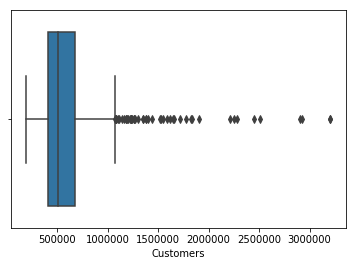

In [132]:
sns.boxplot(base_df['Customers'])

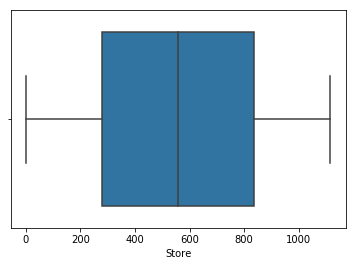

In [133]:
sns.boxplot(base_df['Store'])

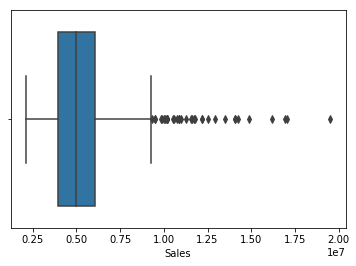

In [134]:
sns.boxplot(base_df['Sales'])

In [135]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [136]:

import cufflinks as cf

In [137]:

# For Notebooks
init_notebook_mode(connected=True)

In [138]:
# For offline use
cf.go_offline()

In [139]:
base_df.iplot(kind='box')

In [140]:
all_outliers=[]
def outliers(base_df):
    for i in base_df.columns:
        print(i)
        q1=np.quantile(base_df[i].values,0.25)
        q3=np.quantile(base_df[i].values,0.75)
        IQR=q3-q1
        lwl=q1-1.5*(IQR)
        uwl=q3+1.5*(IQR)
        outliers=[]
        X=[]
        for j in base_df[i].values:
            if (j<lwl) or (j>uwl):
                outliers.append(j)
                X.append(base_df[i].median())
            else:
                X.append(j)
        print("             ")
        all_outliers.append([i,outliers])
        base_df[i]=X  
            
            
            

In [141]:
outliers(base_df)

Store
             
Customers
             
Sales
             


In [142]:
pd.DataFrame(all_outliers)

,0,1
0,Store,[]
1,Customers,"[1177772.0, 1084610.0, 1233970.0, 1164871.0, 1..."
2,Sales,"[10092722, 10187567, 14896870, 10851871, 98282..."


In [143]:
base_df.iplot(kind='box')

Label Encoder

In [144]:
from sklearn.preprocessing import LabelEncoder
def LabelEncoder(data,cat):
    le=LabelEncoder()
    for i in cat:
        le.fit(data[i])
        transform=le.transform(data[i])
        data[i]=transform
    return data

In [145]:
cont=base_df.describe().columns

cat=[i for i in base_df.columns if i not in base_df.describe().columns]

In [146]:
cat

[]

In [147]:
LabelEncoder(base_df,cat)

TypeError: LabelEncoder() missing 2 required positional arguments: 'data' and 'cat'

MinMax Scalar

In [148]:
from sklearn.preprocessing import MinMaxScaler
def MinMaxScalar(data):
    le=MinMaxScaler()
    le.fit(data)
    x=le.transform(data)
    dat1=pd.DataFrame(x)
    dat1.columns=data.columns
    data=dat1
    return data


In [149]:
MinMaxScalar(base_df)

C:\Users\Administrator\Haritha\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



,Store,Customers,Sales
0,0.000000,0.287274,0.223637
1,0.000898,0.306959,0.246943
2,0.001795,0.450579,0.459677
3,0.002693,0.963870,0.759470
4,0.003591,0.262362,0.213305
5,0.004488,0.349694,0.304704
6,0.005386,0.633727,0.672068
7,0.006284,0.373027,0.310997
8,0.007181,0.299942,0.418342
9,0.008079,0.315824,0.314177


Standard Scalar

In [150]:
from sklearn.preprocessing import StandardScaler
def Standardscalar(data):
    se=StandardScaler()
    se.fit(data)
    x=se.transform(data)
    dat1=pd.DataFrame(x)
    dat1.columns=data.columns
    return data

In [75]:
Standardscalar(base_df)

C:\Users\Administrator\Haritha\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\Administrator\Haritha\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



,Store,Customers,Sales
0,1,440523.0,3716854.0
1,2,457855.0,3883858.0
2,3,584310.0,5408261.0
3,4,1036254.0,7556507.0
4,5,418588.0,3642818.0
5,6,495483.0,4297758.0
6,7,745569.0,6930202.0
7,8,516027.0,4342857.0
8,9,451677.0,5112061.0
9,10,465661.0,4365642.0


In [151]:
base_df.dtypes

Store          int64
Customers    float64
Sales        float64
dtype: object

#### Univariate analysis (EDA)

In [152]:
base_df.head()

,Store,Customers,Sales
0,1,440523.0,3716854.0
1,2,457855.0,3883858.0
2,3,584310.0,5408261.0
3,4,1036254.0,7556507.0
4,5,418588.0,3642818.0


#### Bivarient Analysis

In [153]:
base_df.scatter_matrix()

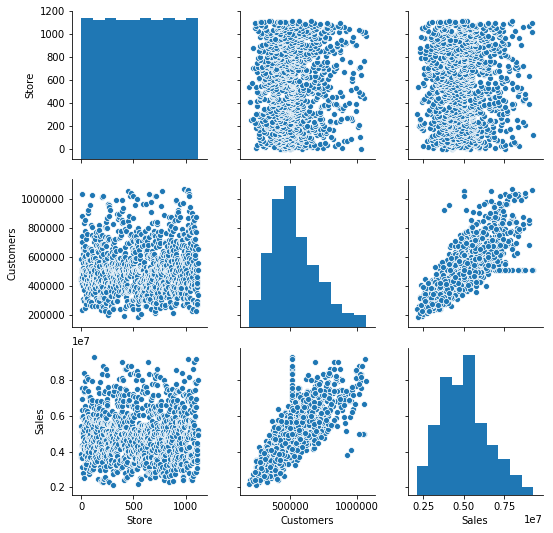

In [154]:
sns.pairplot(base_df)

#### Model Building

In [157]:
# Using the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt

def kelbow(df,k):
    from sklearn.cluster import KMeans
    x = []
    for i in range(1,k):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(df)
        x.append(kmeans.inertia_)

    plt.plot(range(1,k), x)
    plt.title('The elbow method')
    plt.xlabel('The number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return x

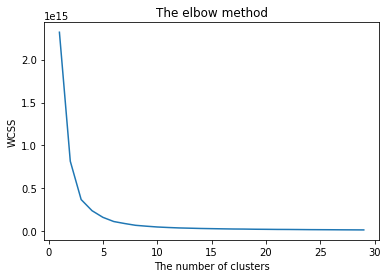

[2318780217015221.0,
 816059250509895.8,
 369634586857491.94,
 240041993744167.62,
 162626766477103.16,
 113824954282396.56,
 90571077708494.27,
 69870109245934.13,
 59452310166366.375,
 50246659939377.49,
 44265378528121.78,
 39240562055875.6,
 36124499939859.02,
 32932366702367.758,
 30780330391294.3,
 28645253262856.96,
 26656638603585.383,
 25796655295932.617,
 23936478338611.938,
 23063473193322.07,
 21803185384189.383,
 21361434232684.914,
 20377366790808.82,
 19322083327884.92,
 18697948852804.46,
 18104166553660.887,
 17249228360281.617,
 16727473237433.594,
 16090750544156.986]

In [158]:
kelbow(base_df,30)

In [159]:
from sklearn.cluster import KMeans

In [160]:
km=KMeans(n_clusters=5)
km.fit(base_df[['Sales','Customers']])
km.predict(base_df[['Sales','Customers']])

array([3, 3, 0, ..., 0, 0, 0])

In [161]:
base_df['culsters']=km.predict(base_df[['Sales','Customers']])

In [162]:
base_df.head()

,Store,Customers,Sales,culsters
0,1,440523.0,3716854.0,3
1,2,457855.0,3883858.0,3
2,3,584310.0,5408261.0,0
3,4,1036254.0,7556507.0,2
4,5,418588.0,3642818.0,3


In [163]:
base_df.rename(columns={'culsters':'clusters'},inplace=True)

In [164]:
base_df.head()

,Store,Customers,Sales,clusters
0,1,440523.0,3716854.0,3
1,2,457855.0,3883858.0,3
2,3,584310.0,5408261.0,0
3,4,1036254.0,7556507.0,2
4,5,418588.0,3642818.0,3


In [165]:
base_df['clusters'].value_counts()

0    342
3    294
1    187
4    182
2    110
Name: clusters, dtype: int64

In [166]:
base_df.shape

(1115, 4)

In [167]:
base_df.head()

,Store,Customers,Sales,clusters
0,1,440523.0,3716854.0,3
1,2,457855.0,3883858.0,3
2,3,584310.0,5408261.0,0
3,4,1036254.0,7556507.0,2
4,5,418588.0,3642818.0,3


In [168]:
base_df['clusters'].value_counts()

0    342
3    294
1    187
4    182
2    110
Name: clusters, dtype: int64

#### Visualizing the clusters

In [169]:
base_df_c1=base_df[base_df.clusters==1]

In [170]:
base_df_c1.head()

,Store,Customers,Sales,clusters
12,13,237740.0,3126578.0,1
21,22,312129.0,2801506.0,1
31,32,296333.0,2526117.0,1
40,41,247531.0,3318407.0,1
45,46,410832.0,3329125.0,1


In [171]:
base_df_c1.shape

(187, 4)

In [172]:
base_df_c1['Sales'].mean()

3097939.668449198

In [173]:
base_df_c1[base_df_c1.Sales<base_df_c1.Sales.mean()]['Store'].values.shape

(82,)

In [174]:
potential_stores=base_df_c1[base_df_c1['Sales']<base_df_c1['Sales'].mean()]

In [175]:
potential_stores

,Store,Customers,Sales,clusters
21,22,312129.0,2801506.0,1
31,32,296333.0,2526117.0,1
47,48,336519.0,3085014.0,1
71,72,295838.0,2753676.0,1
77,78,385990.0,2899629.0,1
82,83,269409.0,3028523.0,1
102,103,266040.0,2959073.0,1
116,117,383319.0,3024044.0,1
164,165,262891.0,2486031.0,1
182,183,367233.0,2945836.0,1


In [176]:
(abs(potential_stores['Sales']-base_df_c1['Sales'].mean()).sum())/potential_stores.shape[0]

370358.375766271